In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.calibration import CalibrationDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import wandb

/Users/yassine/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df_standard = pd.read_csv('dataframe/combined_shots_data.csv')
df_enriched= pd.read_csv('dataframe/train_data_enriched.csv')

In [4]:
df_standard.head(5)

,shot_distance,shot_angle,is_goal,empty_net
0,51.429563,26.565051,0,0
1,30.083218,21.447736,0,0
2,13.000000,22.619865,0,0
3,33.060551,3.468229,0,0
4,38.078866,-13.671307,0,0


In [5]:
df_enriched.columns

Index(['game_id', 'game_seconds', 'game_period', 'x_coord', 'y_coord',
       'shot_distance', 'shot_angle', 'shot_type', 'empty_net',
       'last_event_type', 'last_event_x', 'last_event_y',
       'time_since_last_event', 'distance_from_last_event', 'friendly_skaters',
       'opposing_skaters', 'attacking_team_id', 'attacking_team_name',
       'home_team', 'is_goal', 'rebound', 'shot_angle_change', 'speed'],
      dtype='object')

In [6]:
df_enriched.head(5)

,game_id,game_seconds,game_period,x_coord,y_coord,shot_distance,shot_angle,shot_type,empty_net,last_event_type,...,distance_from_last_event,friendly_skaters,opposing_skaters,attacking_team_id,attacking_team_name,home_team,is_goal,rebound,shot_angle_change,speed
0,2016020001,63,1,-43.0,23.0,51.429563,26.565051,NaN,1,takeaway,...,40.853396,5,5,10,Maple Leafs,Senators,0,False,0.000000,2.042670
1,2016020001,70,1,-61.0,11.0,30.083218,21.447736,NaN,1,blocked-shot,...,21.633308,5,5,10,Maple Leafs,Senators,0,False,0.000000,3.090473
2,2016020001,71,1,-77.0,5.0,13.000000,22.619865,wrist,0,blocked-shot,...,17.088007,5,5,10,Maple Leafs,Senators,0,False,0.000000,17.088007
3,2016020001,125,1,56.0,-2.0,33.060551,3.468229,NaN,1,shot-on-goal,...,133.184083,5,5,9,Senators,Senators,0,True,-19.151636,2.466372
4,2016020001,134,1,52.0,9.0,38.078866,-13.671307,wrist,0,blocked-shot,...,11.704700,5,5,9,Senators,Senators,0,False,0.000000,1.300522


In [7]:
# Categorical features
data_categ = df_enriched.select_dtypes(include=['object'])

# Numerical features
data_numer = df_enriched.select_dtypes(include=['float64', 'int64'])

# Bool features
data_bool = df_enriched.select_dtypes(include=['bool'])

In [8]:
data_categ = data_categ.drop(['attacking_team_name','home_team'], axis=1)

In [9]:
data_categ

,shot_type,last_event_type
0,NaN,takeaway
1,NaN,blocked-shot
2,wrist,blocked-shot
3,NaN,shot-on-goal
4,wrist,blocked-shot
...,...,...
607061,NaN,blocked-shot
607062,wrist,faceoff
607063,wrist,shot-on-goal
607064,wrist,missed-shot


In [10]:
data_numer

,game_id,game_seconds,game_period,x_coord,y_coord,shot_distance,shot_angle,empty_net,last_event_x,last_event_y,time_since_last_event,distance_from_last_event,friendly_skaters,opposing_skaters,attacking_team_id,is_goal,shot_angle_change,speed
0,2016020001,63,1,-43.0,23.0,51.429563,26.565051,1,-81.0,38.0,20,40.853396,5,5,10,0,0.000000,2.042670
1,2016020001,70,1,-61.0,11.0,30.083218,21.447736,1,-43.0,23.0,7,21.633308,5,5,10,0,0.000000,3.090473
2,2016020001,71,1,-77.0,5.0,13.000000,22.619865,0,-61.0,11.0,1,17.088007,5,5,10,0,0.000000,17.088007
3,2016020001,125,1,56.0,-2.0,33.060551,3.468229,1,-77.0,5.0,54,133.184083,5,5,9,0,-19.151636,2.466372
4,2016020001,134,1,52.0,9.0,38.078866,-13.671307,0,56.0,-2.0,9,11.704700,5,5,9,0,0.000000,1.300522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607061,2019030416,3560,3,79.0,-2.0,10.198039,11.309932,1,75.0,-12.0,3,10.770330,6,5,25,0,0.000000,3.590110
607062,2019030416,3567,3,31.0,10.0,58.855756,-9.782407,0,69.0,-22.0,5,49.678969,6,5,25,0,0.000000,9.935794
607063,2019030416,3575,3,84.0,7.0,8.602325,-54.462322,0,31.0,10.0,8,53.084838,6,5,25,0,-44.679915,6.635605
607064,2019030416,3585,3,77.0,0.0,12.000000,-0.000000,0,84.0,7.0,10,9.899495,6,5,25,0,0.000000,0.989949


In [11]:
data_numer = data_numer.drop(['game_id','game_seconds','game_period','time_since_last_event','attacking_team_id'], axis=1)

In [12]:
data_numer

,x_coord,y_coord,shot_distance,shot_angle,empty_net,last_event_x,last_event_y,distance_from_last_event,friendly_skaters,opposing_skaters,is_goal,shot_angle_change,speed
0,-43.0,23.0,51.429563,26.565051,1,-81.0,38.0,40.853396,5,5,0,0.000000,2.042670
1,-61.0,11.0,30.083218,21.447736,1,-43.0,23.0,21.633308,5,5,0,0.000000,3.090473
2,-77.0,5.0,13.000000,22.619865,0,-61.0,11.0,17.088007,5,5,0,0.000000,17.088007
3,56.0,-2.0,33.060551,3.468229,1,-77.0,5.0,133.184083,5,5,0,-19.151636,2.466372
4,52.0,9.0,38.078866,-13.671307,0,56.0,-2.0,11.704700,5,5,0,0.000000,1.300522
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607061,79.0,-2.0,10.198039,11.309932,1,75.0,-12.0,10.770330,6,5,0,0.000000,3.590110
607062,31.0,10.0,58.855756,-9.782407,0,69.0,-22.0,49.678969,6,5,0,0.000000,9.935794
607063,84.0,7.0,8.602325,-54.462322,0,31.0,10.0,53.084838,6,5,0,-44.679915,6.635605
607064,77.0,0.0,12.000000,-0.000000,0,84.0,7.0,9.899495,6,5,0,0.000000,0.989949


In [13]:
# Label encoding
le = LabelEncoder()
data_categ = data_categ.apply(le.fit_transform)
data_categ

# Concatenate all features
df_final= pd.concat([data_categ, data_numer, data_bool], axis=1)
df_final = df_final.dropna()
df_final

,shot_type,last_event_type,x_coord,y_coord,shot_distance,shot_angle,empty_net,last_event_x,last_event_y,distance_from_last_event,friendly_skaters,opposing_skaters,is_goal,shot_angle_change,speed,rebound
0,7,13,-43.0,23.0,51.429563,26.565051,1,-81.0,38.0,40.853396,5,5,0,0.000000,2.042670,False
1,7,0,-61.0,11.0,30.083218,21.447736,1,-43.0,23.0,21.633308,5,5,0,0.000000,3.090473,False
2,6,0,-77.0,5.0,13.000000,22.619865,0,-61.0,11.0,17.088007,5,5,0,0.000000,17.088007,False
3,7,11,56.0,-2.0,33.060551,3.468229,1,-77.0,5.0,133.184083,5,5,0,-19.151636,2.466372,True
4,6,0,52.0,9.0,38.078866,-13.671307,0,56.0,-2.0,11.704700,5,5,0,0.000000,1.300522,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607061,7,0,79.0,-2.0,10.198039,11.309932,1,75.0,-12.0,10.770330,6,5,0,0.000000,3.590110,False
607062,6,2,31.0,10.0,58.855756,-9.782407,0,69.0,-22.0,49.678969,6,5,0,0.000000,9.935794,False
607063,6,11,84.0,7.0,8.602325,-54.462322,0,31.0,10.0,53.084838,6,5,0,-44.679915,6.635605,True
607064,6,7,77.0,0.0,12.000000,-0.000000,0,84.0,7.0,9.899495,6,5,0,0.000000,0.989949,False


In [14]:
X = df_final.drop(['is_goal'], axis =1)
y = df_final['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [15]:
X

,shot_type,last_event_type,x_coord,y_coord,shot_distance,shot_angle,empty_net,last_event_x,last_event_y,distance_from_last_event,friendly_skaters,opposing_skaters,shot_angle_change,speed,rebound
0,7,13,-43.0,23.0,51.429563,26.565051,1,-81.0,38.0,40.853396,5,5,0.000000,2.042670,False
1,7,0,-61.0,11.0,30.083218,21.447736,1,-43.0,23.0,21.633308,5,5,0.000000,3.090473,False
2,6,0,-77.0,5.0,13.000000,22.619865,0,-61.0,11.0,17.088007,5,5,0.000000,17.088007,False
3,7,11,56.0,-2.0,33.060551,3.468229,1,-77.0,5.0,133.184083,5,5,-19.151636,2.466372,True
4,6,0,52.0,9.0,38.078866,-13.671307,0,56.0,-2.0,11.704700,5,5,0.000000,1.300522,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607061,7,0,79.0,-2.0,10.198039,11.309932,1,75.0,-12.0,10.770330,6,5,0.000000,3.590110,False
607062,6,2,31.0,10.0,58.855756,-9.782407,0,69.0,-22.0,49.678969,6,5,0.000000,9.935794,False
607063,6,11,84.0,7.0,8.602325,-54.462322,0,31.0,10.0,53.084838,6,5,-44.679915,6.635605,True
607064,6,7,77.0,0.0,12.000000,-0.000000,0,84.0,7.0,9.899495,6,5,0.000000,0.989949,False


In [16]:
y

0         0
1         0
2         0
3         0
4         0
         ..
607061    0
607062    0
607063    0
607064    0
607065    0
Name: is_goal, Length: 587390, dtype: int64

In [17]:
#param_dist = {
    #'splitter': ['best', 'random'],
    #'max_depth': stats.randint(1, 30),  # Search range for max depth
    #'min_samples_split': stats.randint(2, 11),  # Minimum samples to split
    #'min_samples_leaf': stats.randint(1, 9),  # Minimum samples per leaf
    #'max_features': stats.randint(1, X_train.shape[1] + 1),  # Feature subset selection
    #'criterion': ['gini', 'entropy', 'log_loss'],  # Added 'log_loss' criterion for better probability-based classification
    #'ccp_alpha': stats.uniform(0, 0.05),  # Cost-complexity pruning parameter
    #'class_weight': [None, 'balanced']  # Handle class imbalance
#}

# RandomizedSearchCV configuration
#RSCV_variables = {
    #'estimator': DecisionTreeClassifier(random_state=42),
    #'param_distributions': param_dist,
    #'n_iter': 50,  # Increased number of iterations for more comprehensive search
    #'cv': 5,  # Cross-validation folds
    #'scoring': 'f1',  # Changed to F1-score for better evaluation on class imbalance
    #'random_state': 42,  # Reproducibility
    #'n_jobs': -1  # Parallelize computations
#}

# Perform the search
#rs1 = RandomizedSearchCV(**RSCV_variables)
#rs1.fit(X_train, y_train)

# Extract best parameters
#opt_params1 = rs1.best_params_
#print("Best Parameters:", opt_params1)

# Train the optimized model
#optimized_tree_m1 = DecisionTreeClassifier(**opt_params1, random_state=42)
#optimized_tree_m1.fit(X_train, y_train)

In [18]:
classifier = DecisionTreeClassifier()

param_dist = {
    'splitter': ['best', 'random'],
    'max_depth': stats.randint(1, 30), 
    'min_samples_split': stats.randint(2, 11),  
    'min_samples_leaf': stats.randint(1, 9),  
    'max_features': stats.uniform(0, 1),  
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

RSCV_variables = {
    'estimator': DecisionTreeClassifier(),
    'param_distributions': param_dist,
    'n_iter': 10,
    'cv': 5,
    'scoring': 'accuracy',
    'random_state': 42
}

rs1 = RandomizedSearchCV(**RSCV_variables)
rs1.fit(X_train, y_train)

opt_params1 = rs1.best_params_

optimized_tree_m1 = DecisionTreeClassifier(**opt_params1)
optimized_tree_m1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15,
                       max_features=0.17336465350777208, min_samples_split=5,
                       splitter='random')

In [19]:
y_pred = optimized_tree_m1.predict(X_test)

In [20]:
prob = optimized_tree_m1.predict_proba(X_test)

probs = prob[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, probs)

print(f'Validation Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1-score: {f1*100:.2f}%')
print(f'ROC-AUC Score: {roc_auc*100:.2f}%')

Validation Accuracy: 94.75%
Precision: 46.84%
Recall: 1.76%
F1-score: 3.40%
ROC-AUC Score: 75.47%


In [21]:
metrics = {
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1-score": f1_score(y_test, y_pred),
    }

In [22]:
metrics

{'accuracy': 0.9474568287963137,
 'roc_auc': 0.7547355988604366,
 'precision': 0.46839080459770116,
 'recall': 0.017646421998484357,
 'f1-score': 0.03401147626499739}

In [23]:
wandb.init(project="IFT6758.2024-A", id="Decision_Tree_Q6", resume="allow")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yassine-faik (hicham-mazouzi-university-of-montreal). Use `wandb login --relogin` to force relogin


# Plots

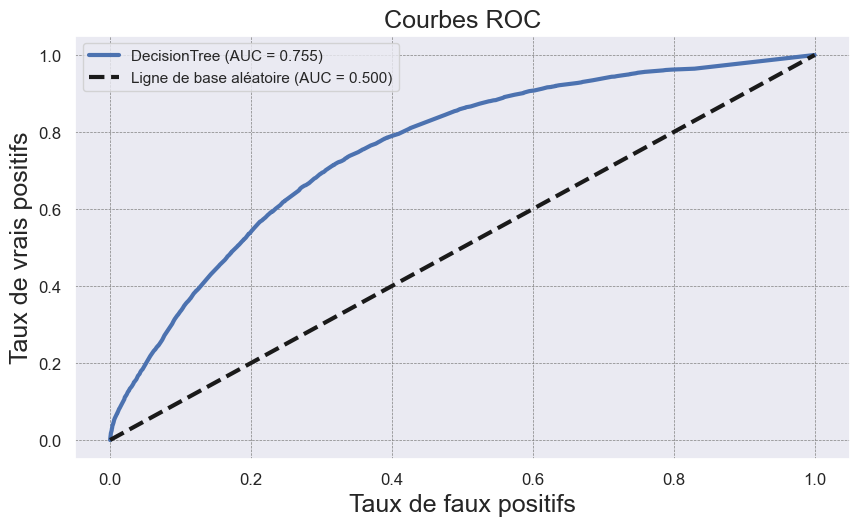

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_score = auc(fpr, tpr)
def courbe_roc_auc(fpr,tpr,auc_score):
    sns.set()

    fig, ax = plt.subplots(figsize=(10, 5.5))

    plt.plot(fpr, tpr, label='DecisionTree (AUC = {:.3f})'.format(auc_score), lw=3)
    plt.plot([0, 1], [0, 1], 'k--', label='Ligne de base aléatoire (AUC = 0.500)', lw=3)

    ax.set_ylabel('Taux de vrais positifs', fontsize=18)
    ax.set_xlabel('Taux de faux positifs', fontsize=18)
    ax.set_title("Courbes ROC", fontsize=18)
    ax.tick_params(labelsize=12)

    plt.legend(loc='best')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    #plt.show()
    plot_filename = "roc_curve_decison_tree.png"
    plt.savefig(plot_filename)
    #return fig
    return fig, plot_filename

roc = courbe_roc_auc(fpr,tpr,auc_score)

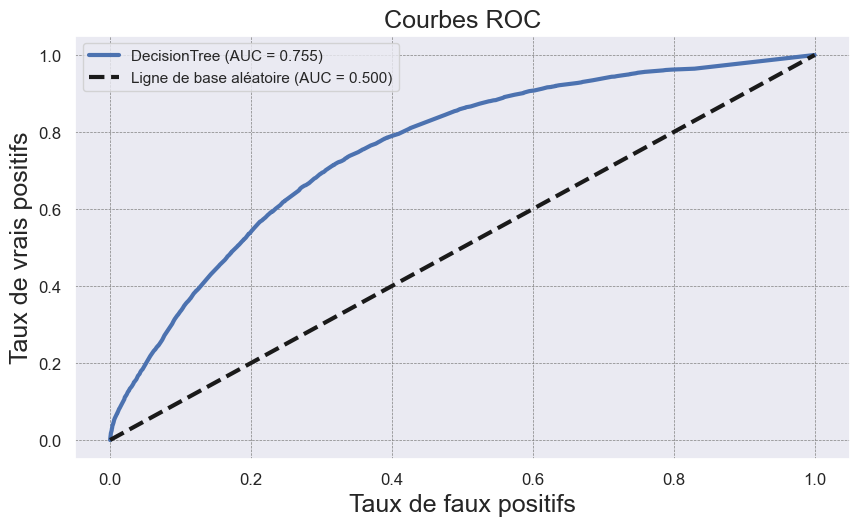

In [25]:
# Initialize Wandb
#wandb.init(project="decision_tree_classification", name="roc_curve_decision_tree")
wandb.init(project="IFT6758.2024-A", id="Decision_Tree_Q6", resume="allow")
# Generate and log the ROC plot
roc_fig, roc_plot_filename = courbe_roc_auc(fpr,tpr,auc_score)

# Log the plot to Wandb
wandb.log({"ROC Curve": wandb.Image(roc_plot_filename)})

# Finish Wandb logging
wandb.finish()

In [26]:
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

def plot_taux_reussite_but(df_prob=None, n_bins=20, quant=5, list_labels=None):
    
    palette_couleurs = ['darkorange', 'green', 'navy', 'red']

    df_prob_1 = df_prob.copy()
    cols = df_prob.columns[1:-1]

    df_percentil, compteur_but, compteur_tir, goal_rate, pencentil = [], [], [], [], []

    for col in cols:
        df_prob_1['percentile'] = df_prob_1[col].rank(pct=True)
        quantile_list = np.linspace(0, 1, n_bins * quant + 1).round(4).tolist()
        q = df_prob_1.quantile(quantile_list)
        for i in np.arange(quant, (quant * n_bins) + 1, quant):
            df_percentil = df_prob_1[((df_prob_1[col] >= q[col][(i - quant) / 100]) & (df_prob_1[col] < q[col][i / 100]))]
            compteur_but.append(df_percentil['IsGoal'].sum())
            compteur_tir.append(df_percentil['compteur_tir'].sum())
            if df_percentil['compteur_tir'].sum() > 0:
                goal_rate.append(df_percentil['IsGoal'].sum() / df_percentil['compteur_tir'].sum())
            else:
                goal_rate.append(0)
            pencentil.append(i)

    # df pour plots
    df_percentil_prop = pd.DataFrame(list(zip(compteur_but, compteur_tir, goal_rate, pencentil)),
                                 columns=['compteur_but', "sum_compteur_tir", 'goal_rate', 'pencentil'])
    df_percentil_prop.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_percentil_prop.dropna(inplace=True)

    # Plots
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    for i in range(len(list_labels)):
        ax = sns.lineplot(x=df_percentil_prop.pencentil[i * n_bins:n_bins * (i + 1) - 1],
                          y=df_percentil_prop.goal_rate[i * n_bins:n_bins * (i + 1) - 1],
                          label=f'{list_labels[i]}', color=palette_couleurs[i], legend=False, linewidth=3)

    ax.set_xlim(left=105, right=-5)
    ax.set_ylim(bottom=0, top=1)
    ax.legend(fontsize=12)
    ax.set_ylabel('But / (Tir + But)')
    ax.set_xlabel('Percentile du modèle de probabilité de tir')
    ax.set_title(f"Taux de réussite des buts vs. Percentile du modèle de probabilité de tir")
    ax.set_xticks(np.arange(0, 101, 10))

   
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter)) # y-axis comme pourcentage
    plot_filename = "goal_success_rate.png"
    plt.savefig(plot_filename)
    
    plt.grid(color='white', linestyle='--', linewidth=0.8)
    #wandb.init(project="IFT6758.2024-A", id="Decision_Tree_Q6", resume="allow")
    wandb.init(project="IFT6758.2024-A", id="Decision_Tree_Q6", resume="allow")
    wandb.log({"Goal Success Rate": wandb.Image("goal_success_rate.png")})
    plt.show()

In [27]:
df_prob = pd.DataFrame({'IsGoal':y_test, 'proba':probs})
df_prob['compteur_tir'] = 1

In [28]:
df_prob

,IsGoal,proba,compteur_tir
265439,0,0.000000,1
93501,0,0.010077,1
136724,0,0.033333,1
588721,0,0.143843,1
24740,0,0.027756,1
...,...,...,...
248419,0,0.007952,1
137087,0,0.000000,1
381850,0,0.032941,1
375589,0,0.046296,1


/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


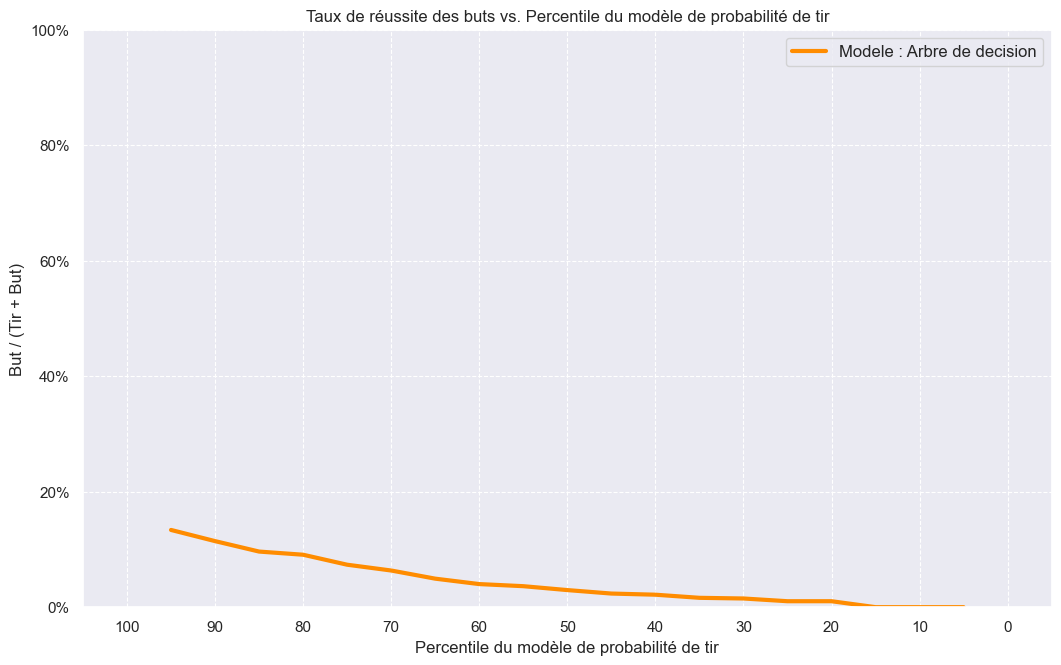

In [29]:
plot_taux_reussite_but(df_prob=df_prob, list_labels=['Modele : Arbre de decision'], n_bins=20, quant=5)

In [30]:
def percentage_formatter(x, pos):
    return f'{x * 100:.0f}%'

def plot_taux_reussite_cumulatif(df_prob=None, n_bins=20, quant=5, list_labels=None):
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    palette_couleurs = ['darkorange', 'green', 'navy', 'red', 'magenta']

    compteur_but, pencentil, cum_goal_rate = [], [], []

    df_prob = df_prob.copy()

    cols = df_prob.columns[1:-1]

    for col in cols:
        temp, j = 0, 100
        df_prob['percentile'] = df_prob[col].rank(pct=True)
        quantile_list = np.linspace(0, 1, n_bins * quant + 1).round(4).tolist()
        q = df_prob.quantile(quantile_list)
        total = df_prob['IsGoal'].sum()

        for j in np.arange((quant * n_bins), 0, -quant):
            df_perc = df_prob[((df_prob[col] > q[col][(j - quant) / 100]) & (df_prob[col] <= q[col][j / 100]))]
            compteur_but.append(df_perc.IsGoal.sum())
            temp += df_perc.IsGoal.sum()
            cum_goal_rate.append(temp / total)
            pencentil.append(j)

    for i in range(len(list_labels)):
        ax = sns.lineplot(x=pencentil[i * n_bins:n_bins * (i + 1) - 1], y=cum_goal_rate[i * n_bins:n_bins * (i + 1) - 1],
                          label=f'{list_labels[i]}', color=palette_couleurs[i], legend=False, linewidth=3)

    sns.set()
    ax.set_xlim(left=105, right=-5)
    ax.set_ylim(bottom=0, top=max(cum_goal_rate) + 0.05)
    ax.set_ylabel('Proportion de buts cumulés')
    ax.set_xlabel('Percentile du modèle de probabilité de tir')
    ax.set_title(f"Taux de réussite cumulatif des buts vs. Percentile du modèle de probabilité de tir")
    ax.legend(fontsize=12)
    plt.grid(color='white', linestyle='--', linewidth=0.8)

    ax.set_xticks(np.arange(0, 101, 10))

     
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter)) # y-axis comme pourcentage
    plot_filename = "cumulative_goals.png"
    plt.savefig(plot_filename)
    
    plt.grid(color='white', linestyle='--', linewidth=0.8)
    #wandb.init(project="decision_tree_classification", id="results", resume="allow")
    wandb.init(project="IFT6758.2024-A", id="Decision_Tree_Q6", resume="allow")
    wandb.log({"Cumulative Goal": wandb.Image("cumulative_goals.png")})
    plt.show()

/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yassine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


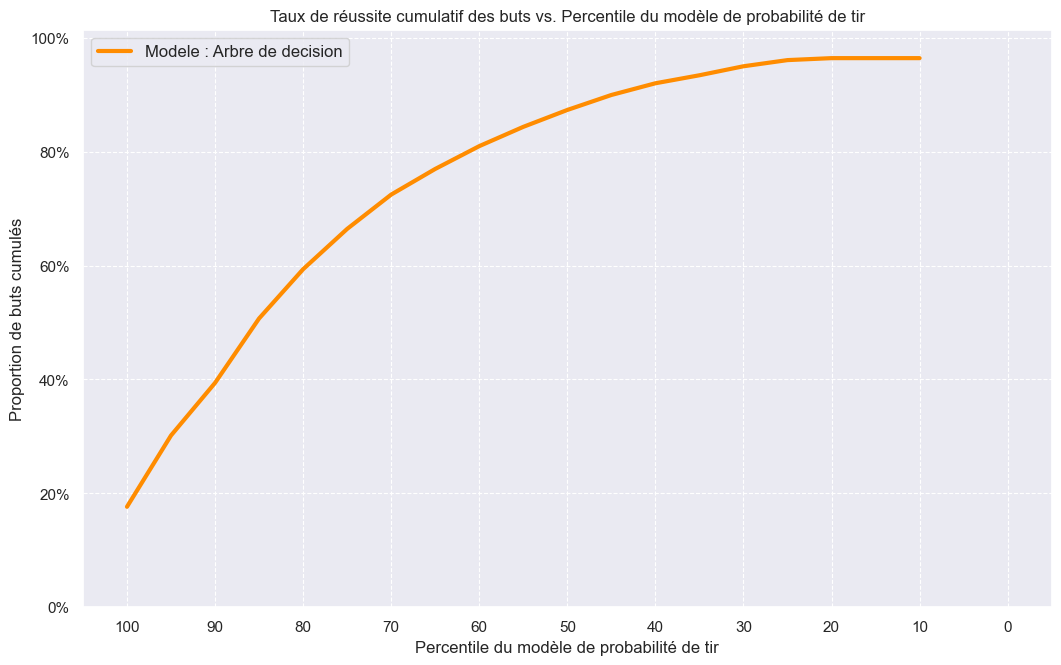

In [31]:
plot_taux_reussite_cumulatif(df_prob=df_prob, n_bins=20, quant=5, list_labels=['Modele : Arbre de decision'])

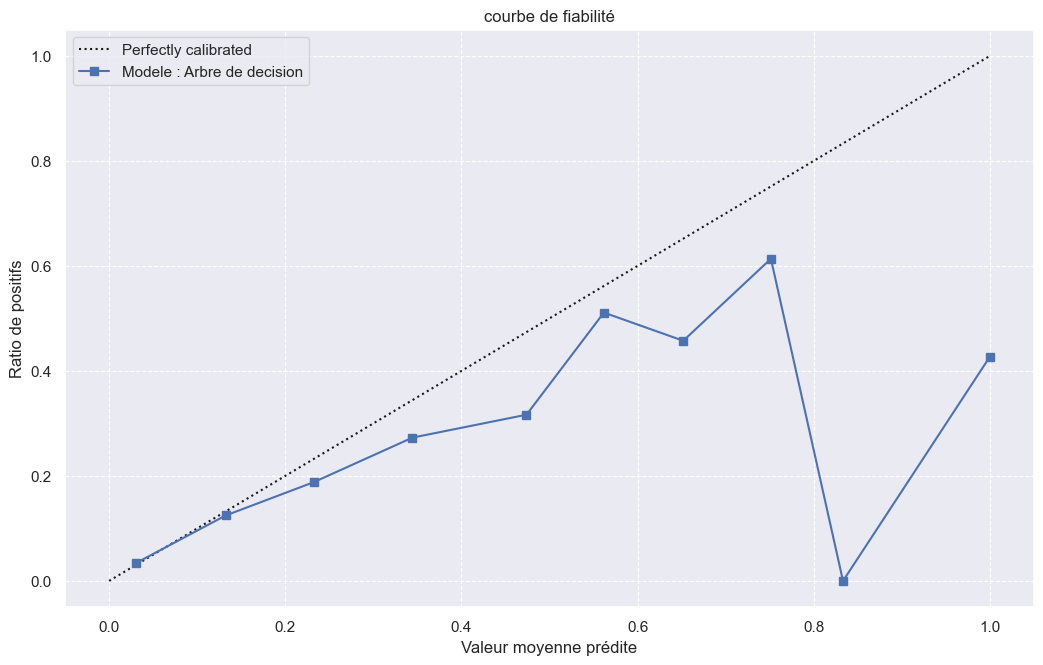

In [32]:
fig, ax = plt.subplots(figsize=(12.5, 7.5))


y_pred_vec = [probs]
y_val = [y_test]
model_names = ['Modele : Arbre de decision']

for idx, y_pred in enumerate(y_pred_vec):
    y_val_flat = np.ravel(y_val[0][:len(probs)]) 
    y_pred_flat = np.ravel(probs)
    disp = CalibrationDisplay.from_predictions(y_val_flat, y_pred_flat, n_bins=10, label=model_names[idx], ax=ax)

sns.set()
ax.set_ylabel("Ratio de positifs")
ax.set_ylim([-0.05, 1.05])
ax.set_title('courbe de fiabilité')
ax.set_xlabel("Valeur moyenne prédite")
ax.set_ylabel("Ratio de positifs")
plt.legend(loc='best')
plt.grid(color='white', linestyle='--', linewidth=0.8)
plt.show()

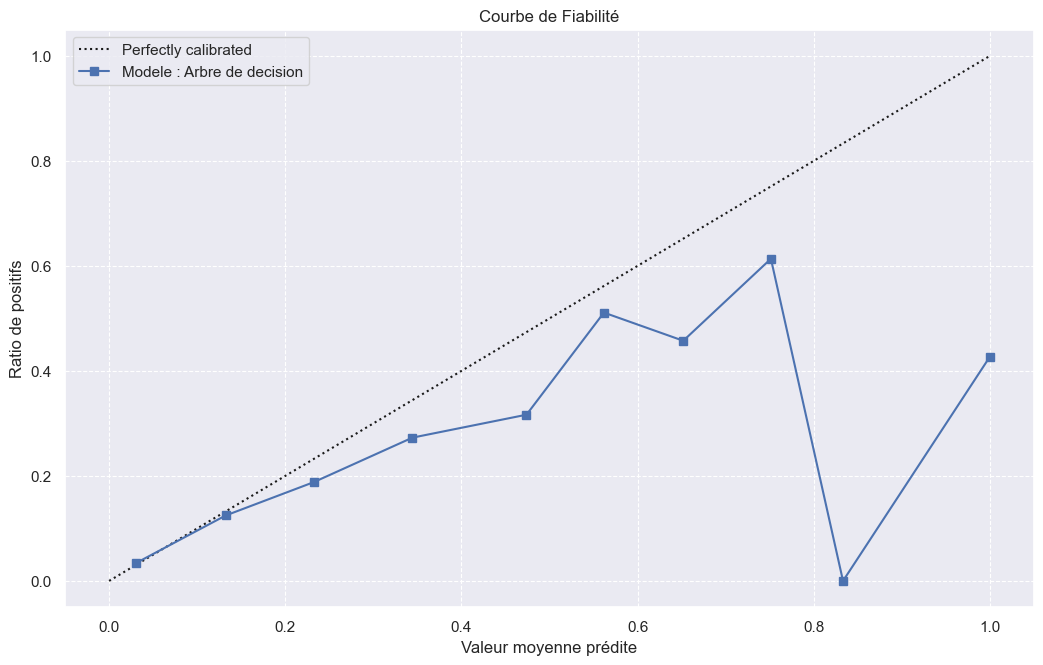

In [33]:
def plot_calibration(y_pred_vec, y_val):
    fig, ax = plt.subplots(figsize=(12.5, 7.5))

    for idx, y_pred in enumerate(y_pred_vec):
        y_val_flat = np.ravel(y_val[idx][:len(y_pred)])  # Flatten and align lengths
        y_pred_flat = np.ravel(y_pred)
        CalibrationDisplay.from_predictions(y_val_flat, y_pred_flat, n_bins=10, label=model_names[idx], ax=ax)

    sns.set()
    ax.set_ylabel("Ratio de positifs")
    ax.set_ylim([-0.05, 1.05])
    ax.set_title('Courbe de Fiabilité')
    ax.set_xlabel("Valeur moyenne prédite")
    plt.legend(loc='best')
    plt.grid(color='white', linestyle='--', linewidth=0.8)

    # Save and log to Wandb
    #wandb.init(project="decision_tree_classification", id="results", resume="allow")
    wandb.init(project="IFT6758.2024-A", id="Decision_Tree_Q6", resume="allow")
    plt.savefig("calibration_plot.png")  # Save locally
    wandb.log({"Calibration Plot": wandb.Image("calibration_plot.png")})  # Log to Wandb
    plt.show()

# Call the function
plot_calibration(y_pred_vec, y_val)

In [34]:
wandb.finish()